## Importing Libraries

In [4]:
import numpy as np
import pandas as pd

## Importing Dataset

In [5]:
# Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('01_AV_MovieLens/ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')

In [6]:
# reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('01_AV_MovieLens/ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

In [7]:
# reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('01_AV_MovieLens/ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')

In [8]:
print("No. of users:", users.shape[0])
print("No. of Ratings:", ratings.shape[0])
print("No. of items:", items.shape[0])

No. of users: 943
No. of Ratings: 100000
No. of items: 1682


In [9]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [10]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [11]:
items.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [15]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' items')

943 users
1682 items


## Creating User-Item Rating Matrix

In [16]:
ratingmtx = np.zeros((n_users, n_items))
for row in ratings.itertuples():
    ratingmtx[row[1]-1, row[2]-1] = row[3]
ratingmtx

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [17]:
sparsity = float(len(ratingmtx.nonzero()[0]))
sparsity /= (ratingmtx.shape[0] * ratingmtx.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.30%


## Noise Detection & Correction

In [60]:
## Classify each rating of the User-Item Rating Matrix into Weak/Average/Strong Preference
## Input: User-item rating matrix 
## Output: Matrix with ratings classified

def rating_classification(UI_mtx, k, v):
    nusers, nmovies = UI_mtx.shape[0], UI_mtx.shape[1]
    r_clss = np.zeros((nusers,nmovies)).astype(str)
    r_clss[:] = ''
    
    for u in range(nusers):
        for m in range(nmovies):
            rui = UI_mtx.iloc[u,m]
            if(rui<k and rui>0):
                r_clss[u][m] = 'W'
            elif(rui>=k and rui<v):
                r_clss[u][m] = 'A'
            elif(rui>=v):
                r_clss[u][m] = 'S'
            else:
                r_clss[u][m] = ''
                
    return r_clss

In [61]:
## User-class classification
## Input: Classified-rating matrix
## Output: User-class list

def user_classification(rss):
    user_class = []
    for u in range(rss.shape[0]):
        S,A,W = 0,0,0
        try:
            S = rss.iloc[u,:].value_counts()['S']
            A = rss.iloc[u,:].value_counts()['A']
            W = rss.iloc[u,:].value_counts()['W']
        except:
            pass
        
        if(W >= A+S):
            user_class.append('Critical')
        elif(A >= W+S):
            user_class.append('Average')
        elif(S >= W+A):
            user_class.append('Benevolent')
        else:
            user_class.append('Variable')
            
    return user_class               

In [62]:
## Item-class classification
## Input: Classified-rating matrix
## Output: Item-class list

def item_classification(rss):
    item_class = []
    for i in range(rss.shape[1]):
        S,A,W = 0,0,0
        try:
            S = rss.iloc[:,i].value_counts()['S']
            A = rss.iloc[:,i].value_counts()['A']
            W = rss.iloc[:,i].value_counts()['W']
        except:
            pass
        
        if(W >= A+S):
            item_class.append('Wp')
        elif(A >= W+S):
            item_class.append('Ap')
        elif(S >= W+A):
            item_class.append('Sp')
        else:
            item_class.append('Vp')
            
    return item_class               

In [74]:
## Noisy rating identification
## Input: classified rating mtx, user classes list, item classes list
## Output: identified noisy/non-noisy ratings mtx

def noise_identification(UI_mtx, k , v):
    rss = pd.DataFrame(rating_classification(UI_mtx,k,v))
    uc = user_classification(rss)
    ic = item_classification(rss)
    
    nusers, nmovies = rss.shape[0], rss.shape[1]
    nmtx = UI_mtx.copy()
    
    for u in range(nusers):
        for m in range(nmovies):
            rc = rss.iloc[u,m]
            if (uc[u]=='Critical' and ic[m]=='Wp' and (rc=='A' or rc=='S')):
                nmtx.iloc[u,m] = k
            if (uc[u]=='Average' and ic[m]=='Ap' and (rc=='W' or rc=='S')):
                nmtx.iloc[u,m] = (k+v)/2.0
            if (uc[u]=='Benevolent' and ic[m]=='Sp' and (rc=='W' or rc=='A')):
                nmtx.iloc[u,m] = v
    
    return nmtx

In [75]:
## Noise Corrected Rating Matrix
nmtx = noise_identification(pd.DataFrame(ratingmtx), 2.0, 4.0)
nmtx.head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,4.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
## Original Rating Matrix
orgmtx = pd.DataFrame(ratingmtx)
orgmtx.head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting Dataset for Training and Testing 

In [20]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [87]:
org_train, org_test = train_test_split(orgmtx.values)
nc_train, nc_test = train_test_split(nmtx.values)

We used the experimental protocol suggested by Gunawardana and Shani. It proposes to select a set of users from the original dataset. Then, randomly select the amount of items nu to hide for each user u, and finally hide nu items at the corresponding u. These hidden items will conform test set, and remaining will be the training set.

## Calculating Similarity

In [88]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in range(ratings.shape[axmax]):
        for uprime in range(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in range(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

In [89]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [90]:
org_user_similarity = fast_similarity(org_train, kind='user')
org_item_similarity = fast_similarity(org_train, kind='item')
nc_user_similarity = fast_similarity(nc_train, kind='user')
nc_item_similarity = fast_similarity(nc_train, kind='item')

## Predicting 

In [91]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

In [92]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [93]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [94]:
org_item_prediction = predict_fast_simple(org_train, org_item_similarity, kind='item')
org_user_prediction = predict_fast_simple(org_train, org_user_similarity, kind='user')
nc_item_prediction = predict_fast_simple(nc_train, nc_item_similarity, kind='item')
nc_user_prediction = predict_fast_simple(nc_train, nc_user_similarity, kind='user')

In [95]:
print('Org User-based CF MSE: ' + str(get_mse(org_user_prediction, org_test)))
print('Org Item-based CF MSE: ' + str(get_mse(org_item_prediction, org_test)))
print('NC User-based CF MSE: ' + str(get_mse(nc_user_prediction, nc_test)))
print('NC Item-based CF MSE: ' + str(get_mse(nc_item_prediction, nc_test)))

Org User-based CF MSE: 8.35142770705
Org Item-based CF MSE: 11.396055460069979
NC User-based CF MSE: 8.83070278395955
NC Item-based CF MSE: 12.238558663674175


## Predicting using Top K

In [96]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [97]:
org_pred = predict_topk(org_train, org_user_similarity, kind='user', k=40)
print('Org Top-k User-based CF MSE: ' + str(get_mse(org_pred, org_test)))

org_pred = predict_topk(org_train, org_item_similarity, kind='item', k=40)
print('Org Top-k Item-based CF MSE: ' + str(get_mse(org_pred, org_test)))

Org Top-k User-based CF MSE: 6.464224511171449
Org Top-k Item-based CF MSE: 7.621258446487721


In [98]:
nc_pred = predict_topk(nc_train, nc_user_similarity, kind='user', k=40)
print('NC Top-k User-based CF MSE: ' + str(get_mse(nc_pred, nc_test)))

nc_pred = predict_topk(nc_train, nc_item_similarity, kind='item', k=40)
print('NC Top-k Item-based CF MSE: ' + str(get_mse(nc_pred, nc_test)))

NC Top-k User-based CF MSE: 6.738707443318238
NC Top-k Item-based CF MSE: 8.038069479220937


In [101]:
k_array = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
org_user_train_mse = []
org_user_test_mse = []
org_item_test_mse = []
org_item_train_mse = []
nc_user_train_mse = []
nc_user_test_mse = []
nc_item_test_mse = []
nc_item_train_mse = []

for k in k_array:
    org_user_pred = predict_topk(org_train, org_user_similarity, kind='user', k=k)
    org_item_pred = predict_topk(org_train, org_item_similarity, kind='item', k=k)
    
    org_user_train_mse += [get_mse(org_user_pred, org_train)]
    org_user_test_mse += [get_mse(org_user_pred, org_test)]
    
    org_item_train_mse += [get_mse(org_item_pred, org_train)]
    org_item_test_mse += [get_mse(org_item_pred, org_test)]
    
    nc_user_pred = predict_topk(nc_train, nc_user_similarity, kind='user', k=k)
    nc_item_pred = predict_topk(nc_train, nc_item_similarity, kind='item', k=k)
    
    nc_user_train_mse += [get_mse(nc_user_pred, nc_train)]
    nc_user_test_mse += [get_mse(nc_user_pred, nc_test)]
    
    nc_item_train_mse += [get_mse(nc_item_pred, nc_train)]
    nc_item_test_mse += [get_mse(nc_item_pred, nc_test)]

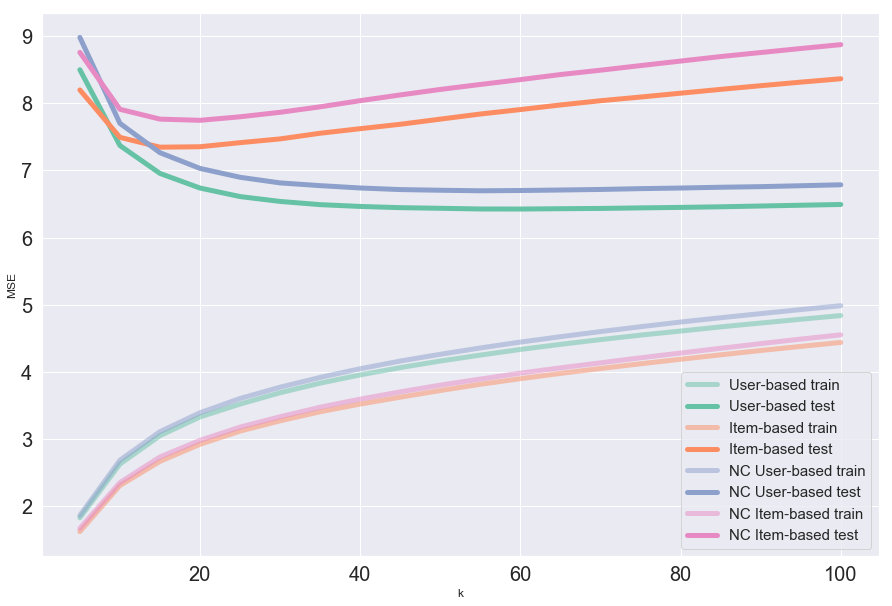

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 4)

plt.figure(figsize=(15, 10))
plt.plot(k_array, org_user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, org_user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, org_item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, org_item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.plot(k_array, nc_user_train_mse, c=pal[2], label='NC User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, nc_user_test_mse, c=pal[2], label='NC User-based test', linewidth=5)
plt.plot(k_array, nc_item_train_mse, c=pal[3], label='NC Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, nc_item_test_mse, c=pal[3], label='NC Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=15)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.xlabel('k');
plt.ylabel('MSE');